# **Converting Sentinel-2 SAFE Format to Cloud-Native Zarr Format**
*by: Gisela Romero Candanedo*


## Why Zarr?

Satellite imagery is essential for environmental monitoring, agriculture, and climate studies. Traditionally, [Sentinel-2](https://documentation.dataspace.copernicus.eu/Data/SentinelMissions/Sentinel2.html) data is stored in `.SAFE` format, which is structured but not optimized for cloud-based workflows.<br> New storing formats such as `.zarr`, allows chunked and compressed storage, making large datasets manageable and quickly accessible, even in cloud environments.  This conversion is particularly useful for machine learning, big data analysis, and remote sensing applications.

In this notebook we will demonstrate how to efficiently convert Sentinel-2 Level 2A `.SAFE` images into `.zarr`, a cloud-native format designed for fast access and scalable storage.

To deep dive into `.zarr` applications for geodaata storage, visit the [Cloud-Optimized Geospatial Formats Guide](https://guide.cloudnativegeo.org/zarr/intro.html).

## Dataset Overview
The Sentinel-2 mosaic used in this tutorial was captured over the alpine region in the Province of South Tyrol, close to Bolzanon, Italy (46.4949° N, 11.3403° E). This location was chosen based on its diverse terrain and land cover, which offer a wide range of spectral reflectance values.<br>
This variation makes it an excellent case study for testing and validating different spectral bands.

The dataset was retrieved from the [Copernicus Browser](https://browser.dataspace.copernicus.eu/) and corresponds to a Sentinel-2 L2A mosaic retrived on May 3th 2020 at 10:05:49.

### *Sections in this notebook:*
**1. Setting Up the Environment**- Importing necessary libraries.<br>
**2. Reading Sentinel-2 SAFE Files** - Extracting bands and metadata.<br>
**3. Processing and Storing Data in Zarr** - Optimizing storage with chunking and compression.<br>
**4. Verify Output** - Ensuring data consistency.<br>
**5. Comparing SAFE and Zarr** - Verification.<br>


### Prerequisites

When downloading this guide, the following file needs to be stored in the same location as this `.ipynb`:

`S2B_MSIL2A_20200503T100549_N0500_R022_T32TPS_20230426T232254.SAFE`

Our example, is adapted to proces the 12 relevant bands from [Sentinel-2 L2A](https://sentiwiki.copernicus.eu/web/s2-products#S2Products-L2AProductsS2-Products-L2Atrue) mosaics which are often used for environmental research.

Additionally, working in a specific and stable environment is recommended. To ensure compatibility and no conflict among packages, the following virtual environment is recommended:

for conda:<br>
`conda create --name safetozarr python=3.11 os xarray rioxarray zarr numpy imageio matplotlib rasterio xmltodict`<br>
for pip:<br>
`pip install os xarray rioxarray zarr numpy imageio matplotlib rasterio xmltodict`

# 1. Setting Up the Environment

Each of these libraries plays a crucial role in processing, storing, and analyzing the Sentinel-2 L2A dataset

In [10]:
# Import required libraries
import os
import xml.etree.ElementTree as ET
import rioxarray
import xarray as xr
import zarr
import json
import matplotlib.pyplot as plt

## 1.1. Defining SAFE File input and each of the Granule Extraction
Sentinel-2 `.SAFE` files contain multiple granules, where each granule represents a portion of the image at different resolutions (10m, 20m, and 60m).

We dynamically detect and extract the granule folder from the `.SAFE` directory.
This ensures that the workflow adapts to different Sentinel-2 files without requiring manual intervention.

In [11]:
#We define the name of the .SAFE file to be transformed. The .jp2 bands are usually stored under 'IMG_DATA'
safe_input = "S2B_MSIL2A_20200503T100549_N0500_R022_T32TPS_20230426T232254.SAFE"
granule_path = os.path.join(safe_input, "GRANULE")
granules = os.listdir(granule_path)
granule_folder = os.path.join(granule_path, granules[0], "IMG_DATA")

## 1.2. Defining Band Resolutions and Chunk Sizes

We define chunk sizes for each resolution. Chunks control how data is read and stored, significantly impacting performance. Optimized chunking ensures that Zarr compression works efficiently while maintaining quick access to individual data slices.
Sentinel-2 mosaics come in different resolutions:

- **10m**: B02, B03, B04, B08 (higher resolution, includes RGB and NIR bands)
- **20m**: B05, B06, B07, B8A, B11, B12 (includes vegetation and SWIR bands)
- **60m**: B01, B09 (atmospheric correction bands)

According to the [Optimizing performance](https://zarr.readthedocs.io/en/stable/user-guide/performance.html) Zarr python documentation, chunks of at least 1 megabyte (1M) uncompressed size seem to provide better performance, at least when using the Blosc compression library.
The optimal chunk shape will depend on how you want to access the data. E.g., for a 2-dimensional array, if you only ever take slices along the first dimension, then chunk across the second dimension.


In [12]:
#Our defined chunks (you can adapt them to your needs)
chunk_sizes = {
    "R10m": (1024, 1024),
    "R20m": (512, 512),
    "R60m": (128,128)
}
# This dictionary will allow th workflow to retrieve based on the existing folders in granule_folder retrieve the desired bands
band_resolutions = {
    "R10m": ["B02", "B03", "B04", "B08"],
    "R20m": ["B05", "B06", "B07", "B8A", "B11", "B12"],
    "R60m": ["B01", "B09"]
}

# 2. Reading Sentinel-2 SAFE Files

Now, each spectral band is extracted and processed, as:

- The counters loop through the different resolutions (R10m, R20m, R60m).
- Each band is read using `rioxarray` and converted into an `xarray.Dataset()`.

This step ensures that all Sentinel-2 bands are structured correctly before metadata extraction and storage.

In [13]:
#The groups will be extracted in xarray.Dataset arrays, allowing us to define the chunking storage sized and identifiers for a further compression
datasets = {}

#Setting the counter inside the specific resolution folder:
 
for res_folder, bands in band_resolutions.items():
    res_path = os.path.join(granule_folder, res_folder)
    data_vars = {}

#Setting the counter so it retrieves data for each defined band    
    for band_name in bands:
        band_path = os.path.join(res_path, f"T32TPS_20200503T100549_{band_name}_{res_folder[1:]}.jp2")
        if os.path.exists(band_path):
                  
            #extracting the reflectance values from the corresponding .SAFE .jp2 band
            band = rioxarray.open_rasterio(band_path, masked=True, overview_level=0).squeeze()
            
            #Defining the chunk sizes previously defined in 1.1 for index definition and a further compression
            data_vars[band_name] = band.chunk({"x": chunk_sizes[res_folder][0], "y": chunk_sizes[res_folder][1]})
    
    #Adding the geolocation data from the original .SAFE band
    if data_vars:
        datasets[res_folder] = xr.Dataset(data_vars, coords={"x": band.x, "y": band.y})

#The datasets stored are :
datasets

{'R10m': <xarray.Dataset> Size: 482MB
 Dimensions:      (x: 5490, y: 5490)
 Coordinates:
     band         int32 4B 1
   * x            (x) float64 44kB 6e+05 6e+05 6e+05 ... 7.098e+05 7.098e+05
   * y            (y) float64 44kB 5.2e+06 5.2e+06 5.2e+06 ... 5.09e+06 5.09e+06
     spatial_ref  int32 4B 0
 Data variables:
     B02          (y, x) float32 121MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
     B03          (y, x) float32 121MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
     B04          (y, x) float32 121MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
     B08          (y, x) float32 121MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>,
 'R20m': <xarray.Dataset> Size: 181MB
 Dimensions:      (x: 2745, y: 2745)
 Coordinates:
     band         int32 4B 1
   * x            (x) float64 22kB 6e+05 6.001e+05 ... 7.097e+05 7.098e+05
   * y            (y) float64 22kB 5.2e+06 5.2e+06 5.2e+06 ... 5.09e+06 5.09e+06
     spatial_ref  int32 4B 0
 Data vari

## 2.1 Extracting interest Metadata from `.SAFE`'s `.xml` files to store it in `.zarr` corresponding layers

Metadata provides essential information about the dataset, such as:

- Satellite Name & Sensor Type
- Processing Level & Projection (EPSG Code)
- Tile ID and Sensing Time
- Cloud Coverage Information

We extract this metadata from the `.SAFE`'s Sentinel-2 `MTD_MSIL2A.xml` and `MTD_TL.xml` files. By embedding this metadata in the Zarr dataset, users can retrieve critical information without needing to reference external files.

In [14]:
#Retrieves main metadata set
metadata_file = os.path.join(safe_input, "MTD_MSIL2A.xml")

#Restrieves specific metadata from the granules stored in .SAFE
dtree = ET.parse(os.path.join(safe_input, "GRANULE", os.listdir(os.path.join(safe_input, "GRANULE"))[0], "MTD_TL.xml"))

#Acceses the .xml file so we can parse it and search for specific strings.
tree = ET.parse(metadata_file)
root = tree.getroot()
droot = dtree.getroot()

#Select relevant information so further processes could be performed over the new dataset.
safe_metadata = {
    "satellite": root.findtext(".//SPACECRAFT_NAME"),
    "sensor": root.findtext(".//DATATAKE_TYPE"),
    "processing_level": root.findtext(".//PROCESSING_LEVEL"),
    "epsg": root.findtext(".//HORIZONTAL_CS_CODE"),
    "tile_id": droot.findtext(".//TILE_ID"),
    "product_type": root.findtext(".//PRODUCT_TYPE"),
    "sensing_time": root.findtext(".//PRODUCT_START_TIME")[11:19],
    "cloud_coverage": root.findtext(".//CLOUD_SHADOW_PERCENTAGE"),
}

# 3. Processing and Storing Data in Zarr
This is the core step where we store Sentinel-2 bands in a cloud-friendly `.zarr` format:

We define Blosc compression to reduce file size while maintaining data quality. Each resolution level (R10m, R20m, R60m) is stored as a separate group inside the Zarr dataset. <br>
Metadata is embedded directly into the Zarr file for easy retrieval.
By using chunked compression, we ensure that the dataset remains efficient for both local analysis and cloud-based workflows.

In [ ]:
# Defining the stage of compression will allow each of the arrays (bands) to be stored optimally and easily retrieved from the cloud.
# Zarr includes Blosc, Zstandard, and Gzip compressors. 
compressor = zarr.Blosc(cname="zstd", clevel=6, shuffle=zarr.Blosc.SHUFFLE)

# The output file is defined
out_zarr = "S2B_MSIL2A_20200503T100549_N0500_R022_T32TPS_20230426T232254.zarr"
store = zarr.DirectoryStore(out_zarr)

# Each band is stored by resolution, as the chunking was defined in different sizes for each given resolution
for res_folder, dataset in datasets.items():
    dataset.to_zarr(
        store=store, 
        group=res_folder, 
        mode="w", 
        consolidated=True,
        encoding={band_name: {"compressor": compressor} for band_name in dataset.data_vars}  # Apply compression to each band
    )

#The generated metadata in the process as to describe the .zarr structure is stored in the directory
zarr.consolidate_metadata(store)

#Stores the chosen metadata over the .SAFE format to .zarr format
zarr.save(out_zarr + "/metadata.json", json.dumps(safe_metadata))


# 4. Verify Output
Here, we are able to visualize the complete structure of the stored `.zarr` and ensure all the bands were stored inside their corresponding reoslution.

In [16]:
# Visualizing the structure for each of the resolutions inside the .zarr and confirm chunk sizing
print("Final dataset structure:")
for res_folder in datasets.keys():
    print(f"{res_folder}: {xr.open_zarr(out_zarr, group=res_folder)}")

Final dataset structure:
R10m: <xarray.Dataset> Size: 482MB
Dimensions:      (y: 5490, x: 5490)
Coordinates:
    band         int32 4B ...
  * x            (x) float64 44kB 6e+05 6e+05 6e+05 ... 7.098e+05 7.098e+05
  * y            (y) float64 44kB 5.2e+06 5.2e+06 5.2e+06 ... 5.09e+06 5.09e+06
Data variables:
    B02          (y, x) float32 121MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    B03          (y, x) float32 121MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    B04          (y, x) float32 121MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    B08          (y, x) float32 121MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    spatial_ref  int32 4B ...
R20m: <xarray.Dataset> Size: 181MB
Dimensions:      (y: 2745, x: 2745)
Coordinates:
    band         int32 4B ...
  * x            (x) float64 22kB 6e+05 6.001e+05 ... 7.097e+05 7.098e+05
  * y            (y) float64 22kB 5.2e+06 5.2e+06 5.2e+06 ... 5.09e+06 5.09e+06
Data variables:
    B05        

# 5. Comparing SAFE and Zarr

The band print allows us to visualize data's consistency, orientation and scaling between the original `.SAFE` file and the compressed `.zarr`. 

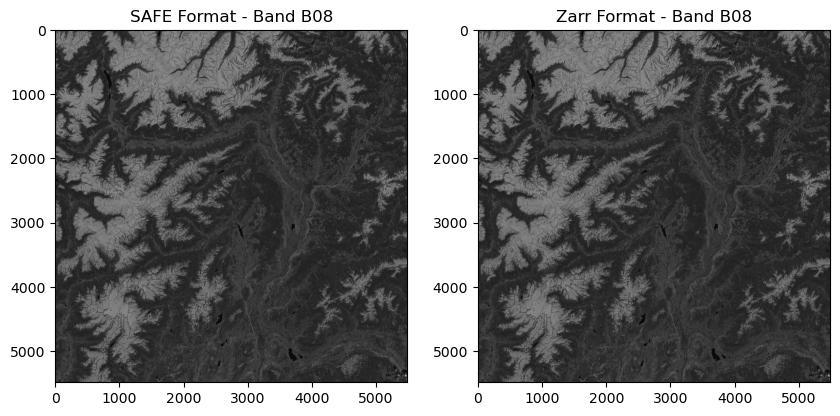

In [17]:
# Comparing visually the 4th Band in SAFE and Zarr
band_name = "B08"
safe_band = datasets["R10m"][band_name]
zarr_band = xr.open_zarr(out_zarr, group="R10m")[band_name]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(safe_band, cmap="gray")
plt.title("SAFE Format - Band B08")

plt.subplot(1, 2, 2)
plt.imshow(zarr_band, cmap="gray")
plt.title("Zarr Format - Band B08")

plt.show()

Also, calculating the file size proofs the compression was generated successfully.

In [18]:
# Comparing File Sizes of SAFE and Zarr in GB
safe_size = sum(os.path.getsize(os.path.join(dp, f)) for dp, dn, filenames in os.walk(safe_input) for f in filenames) / (1024**3)
zarr_size = sum(os.path.getsize(os.path.join(dp, f)) for dp, dn, filenames in os.walk(out_zarr) for f in filenames) / (1024**3)

print(f"SAFE Directory Size: {safe_size:.2f} GB")
print(f"Zarr Directory Size: {zarr_size:.2f} GB")

SAFE Directory Size: 1.18 GB
Zarr Directory Size: 0.25 GB


# Conclusion

This workflow makes it easier to handle large Sentinel-2 datasets, especially when working with cloud platforms or big data analytics. It can also further support the conversion for analytics in shared and cloud-based projects.

After exploring the `.zarr` file obtained from this workflow, you will realize the levels of compression, the chunks storage and the difference in size, as it reduces the total storage space in 30%-60%.


For more information on this methodologies and specific information about Sentinel-2 documentation and structure visit:

- [Zarr documentation ](https://zarr-specs.readthedocs.io/en/latest/v3/core/v3.0.html)

- [Another Zarr aplication Example from Pangeo](https://colab.research.google.com/github/tyson-swetnam/agic-2022/blob/main/docs/notebooks/zarr.ipynb#scrollTo=e9c1b4e5-b9c6-41c5-aac9-dfdfd884335c)

- [COG Formats guide](https://guide.cloudnativegeo.org/zarr/zarr-in-practice.html)

- [Sentinel 2 Documentation](https://documentation.dataspace.copernicus.eu/Data/SentinelMissions/Sentinel2.html)

We encourage you to test out other mosaics retrieved from Sentinel-2,  different chunking sizes for each band, and compression methodologies, as you can adapt this code to your needs!

`Happy EO coding!! :)`
